In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import yfinance as yf # type: ignore

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Load financial data

In [2]:
data = yf.download('AAPL')

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800
1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000
1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600
1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600


In [4]:
X = data.to_numpy()
X.shape

(11094, 6)

In [5]:
def create_sequence(data: np.ndarray, seq_len: int = 8, target_sequence: bool = False) -> tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    for i in range(len(data) - seq_len - 1):
        X.append(data[i:i+seq_len])
        if target_sequence:
            y.append(data[(i+1):(i+1+seq_len)])
        else:
            y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# Split and scale

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_X = StandardScaler()
#scaler_X = MinMaxScaler(feature_range=(0, 1))

X_train, X_test = train_test_split(X, test_size=0.2)

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (8875, 6), Test: (2219, 6)


# Create sequences

In [7]:
X_train, y_train = create_sequence(X_train, seq_len=10)
X_test, y_test = create_sequence(X_test, seq_len=7)

print(f'X, y_train: {X_train.shape} {y_train.shape}')
print(f'X, y_test: {X_test.shape} {y_test.shape}')

X, y_train: (8864, 10, 6) (8864, 6)
X, y_test: (2211, 7, 6) (2211, 6)


In [8]:
#y_train, y_test = y_train.reshape(-1, 1, 6), y_test.reshape(-1, 1, 6)
#print(f'y_train, y_test: {y_train.shape}, {y_test.shape}')

# Custom dataset

In [9]:
class StockDataset(Dataset):

    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

# Data preparation

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train, X_test, y_train, y_test = torch.Tensor(X_train), torch.Tensor(X_test), torch.Tensor(y_train), torch.Tensor(y_test)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [11]:
batch_size = 64

dataset_train = StockDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [12]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=6, dropout=0.1):
        super(GRUModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.gru = nn.GRU(input_size=input_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            dropout=dropout,
                            batch_first=True)
        
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        ula, h_out = self.gru(x, h_0)
        h_out = h_out[-1, :, :]
        out = self.fc_out(h_out)
        
        return out

In [13]:
n_features = 6

model = GRUModel(input_dim=n_features, output_dim=n_features, hidden_dim=128, num_layers=3, dropout=0.3)
model = model.to(device)

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()

for epoch in range(100):

    epoch_loss = 0

    for data, target in dataloader_train:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if epoch % 5 == 0:
        print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(dataloader_train)}")

Epoch: 1, Loss: 1.0075789312664554
Epoch: 6, Loss: 1.0066331421299803
Epoch: 11, Loss: 1.0063908151585421
Epoch: 16, Loss: 1.005379901515494
Epoch: 21, Loss: 1.003304985787371
Epoch: 26, Loss: 0.9997485811761815
Epoch: 31, Loss: 0.9934187276329068
Epoch: 36, Loss: 0.9668232541290118
Epoch: 41, Loss: 0.9176498117635576
Epoch: 46, Loss: 0.8364155955023045
Epoch: 51, Loss: 0.7294962442607331
Epoch: 56, Loss: 0.6379172630447278
Epoch: 61, Loss: 0.577753603887215
Epoch: 66, Loss: 0.5008618156258151
Epoch: 71, Loss: 0.4470941564805216
Epoch: 76, Loss: 0.3974093441054118
Epoch: 81, Loss: 0.35895239845883076
Epoch: 86, Loss: 0.3391109513078662
Epoch: 91, Loss: 0.31025619611894484
Epoch: 96, Loss: 0.28295719537803593


In [15]:
model.eval()

with torch.no_grad():

    val_output = model(X_test)
    val_loss = criterion(val_output, y_test)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 1.668798565864563


In [16]:
true_unscaled = scaler_X.inverse_transform(y_test.cpu())[:20]
predicted_unscaled = scaler_X.inverse_transform(val_output.cpu())[:20]
print(f'Shapes: {true_unscaled.shape}, {predicted_unscaled.shape}')

Shapes: (20, 6), (20, 6)


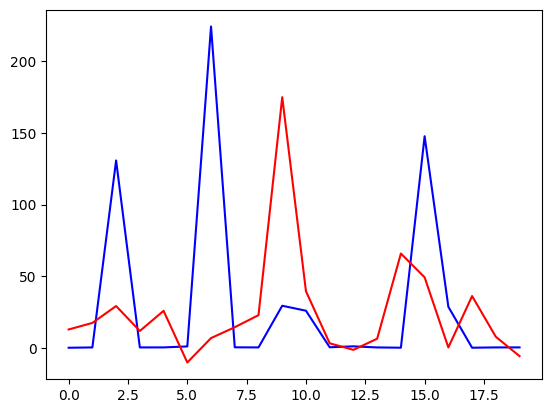

In [17]:
x = [i for i in range(len(true_unscaled))]
plt.plot(x, true_unscaled[:, 0], color='blue')
plt.plot(x,predicted_unscaled[:, 0], color='red')
plt.show()